Bajar el dataset de imagenes desde google drive

In [1]:
dataset_path = "./Oral-Diseases-DataSet"

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [3]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64

In [4]:
val_path = 'Oral-Diseases-DataSet/val'
train_path = 'Oral-Diseases-DataSet/train'
test_path = 'Oral-Diseases-DataSet/test'

In [5]:
def dataset():
  rescale = tf.keras.layers.Rescaling(1./255)
  training_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=train_path,
        batch_size=BATCH_SIZE,
        image_size=IMAGE_SIZE,
        shuffle=True,
        seed=42,
    )

  validation_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=val_path,
        batch_size=BATCH_SIZE,
        image_size=IMAGE_SIZE,
        shuffle=True,
        seed=42,
    )
  test_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=test_path,
        batch_size=BATCH_SIZE,
        image_size=IMAGE_SIZE,
        shuffle=True,
        seed=42,
    )

  training_dataset = training_dataset.map(lambda x, y: (rescale(x), y))
  validation_dataset = validation_dataset.map(lambda x, y: (rescale(x), y))
  test_dataset = test_dataset.map(lambda x, y: (rescale(x), y))

  return training_dataset, validation_dataset, test_dataset

In [6]:
training_dataset, validation_dataset, test_dataset = dataset()

Found 11683 files belonging to 6 classes.
Found 1410 files belonging to 6 classes.
Found 1410 files belonging to 6 classes.


In [7]:
def create_pre_trained_model():
  pre_trained_model = InceptionV3(
      input_shape=(224, 224, 3),
      include_top=False,
      weights='imagenet',
  )

  for layer in pre_trained_model.layers:
    layer.trainable = False

  return pre_trained_model

In [8]:
pre_trained_model = create_pre_trained_model()

In [9]:
def output_last_layer(pre_trained_model):
  last_layer = pre_trained_model.get_layer('mixed7')
  last_output = last_layer.output
  print('last layer output shape: ', last_output.shape)

  return last_output

In [10]:
last_output = output_last_layer(pre_trained_model)

last layer output shape:  (None, 12, 12, 768)


In [11]:
def main_model(pre_trained_model, last_output):
  x = tf.keras.layers.Flatten()(last_output)
  x = tf.keras.layers.Dense(1024, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  predictions = tf.keras.layers.Dense(6, activation='softmax')(x)

  model = tf.keras.Model(inputs=pre_trained_model.input, outputs=predictions)

  model.compile(
      optimizer=Adam(),
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy'],
  )

  return model

In [12]:
model = main_model(pre_trained_model, last_output)

In [13]:
# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 122,228,646 total parameters in this model.
There are 113,253,382 trainable parameters in this model.


In [14]:
history = model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=1,
    verbose=1
)

183/183 ━━━━━━━━━━━━━━━━━━━━ 611s 3s/step - accuracy: 0.6249 - loss: 2.8513 - val_accuracy: 0.7191 - val_loss: 1.1003


In [15]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

def create_augmented_model(pre_trained_model, last_output):
    x = data_augmentation(pre_trained_model.input)
    x = pre_trained_model(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)  # Increased dropout
    predictions = tf.keras.layers.Dense(6, activation='softmax')(x)
    model = tf.keras.Model(inputs=pre_trained_model.input, outputs=predictions)
    model.compile(
        optimizer=Adam(learning_rate=1e-4),  # Reduced learning rate
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [16]:
def create_fine_tuned_model():
    pre_trained_model = InceptionV3(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    # Unfreeze some top layers for fine-tuning
    for layer in pre_trained_model.layers[-50:]:
        layer.trainable = True

    x = tf.keras.layers.GlobalAveragePooling2D()(pre_trained_model.output)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    predictions = tf.keras.layers.Dense(6, activation='softmax')(x)

    model = tf.keras.Model(inputs=pre_trained_model.input, outputs=predictions)

    model.compile(
        optimizer=Adam(learning_rate=1e-5),  # Very low learning rate for fine-tuning
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

history = model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=50,  # More epochs with early stopping
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

Epoch 1/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 618s 3s/step - accuracy: 0.9017 - loss: 0.2544 - val_accuracy: 0.7376 - val_loss: 1.3704 - learning_rate: 0.0010
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 565s 3s/step - accuracy: 0.9337 - loss: 0.1679 - val_accuracy: 0.7447 - val_loss: 1.2464 - learning_rate: 0.0010
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 566s 3s/step - accuracy: 0.9421 - loss: 0.1398 - val_accuracy: 0.7603 - val_loss: 1.2161 - learning_rate: 0.0010
Epoch 4/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 571s 3s/step - accuracy: 0.9467 - loss: 0.1225 - val_accuracy: 0.7440 - val_loss: 1.4414 - learning_rate: 0.0010
Epoch 5/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 576s 3s/step - accuracy: 0.9455 - loss: 0.1264 - val_accuracy: 0.7631 - val_loss: 1.1719 - learning_rate: 0.0010
Epoch 6/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 576s 3s/step - accuracy: 0.9514 - loss: 0.1189 - val_accuracy: 0.7532 - val_loss: 1.4617 - learning_rate: 0.0010
Epoch 7/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 575s 3s/step - accuracy: 0.9486 - loss: 0.

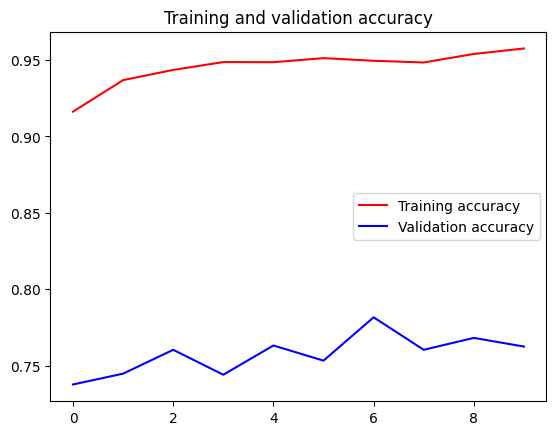

In [19]:
# Plot the training and validation accuracies for each epoch
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show()

In [ ]:

model.save('oral-diseases-model-inceptionv3.keras')